# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [272]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [273]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

C:\Users\Leo\Anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [274]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

C:\Users\Leo\Anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [275]:
# your turn. 
df_merge = df_transactions.merge(df_offers, on='offer_id', how='inner')
df_pivot = df_merge.pivot_table(index='customer_name', columns='offer_id', values='n', fill_value=0)
print(df_pivot.head())

offer_id       1   2   3   4   5   6   7   8   9   10 ...  23  24  25  26  27  \
customer_name                                         ...                       
Adams           0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
Allen           0   0   0   0   0   0   0   0   1   0 ...   0   0   0   0   1   
Anderson        0   0   0   0   0   0   0   0   0   0 ...   0   1   0   1   0   
Bailey          0   0   0   0   0   0   1   0   0   0 ...   0   0   0   0   0   
Baker           0   0   0   0   0   0   1   0   0   1 ...   0   0   0   0   0   

offer_id       28  29  30  31  32  
customer_name                      
Adams           0   1   1   0   0  
Allen           0   0   0   0   0  
Anderson        0   0   0   0   0  
Bailey          0   0   1   0   0  
Baker           0   0   0   1   0  

[5 rows x 32 columns]


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

What values of  SSSS  do you believe represent better clusterings? Why?
* Smaller values of SS represent better clusterings because that means that the data points within the same clusters are more similar to each other. 

In [276]:
# your turn.
## Create a numpy matrix x_cols with only the columns representing the offers (i.e. the 0/1 colums)
x_cols = np.matrix(df_pivot)
print(x_cols)
print(type(x_cols))

[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 1]]
<class 'numpy.matrixlib.defmatrix.matrix'>


In [277]:
## Write code that applies the KMeans clustering method from scikit-learn to this matrix.
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
clusters = range(2,11)
sse = []

for k in clusters:
    model = KMeans(n_clusters=k)
    labels = model.fit_predict(x_cols)
    sse.append(model.inertia_)
    ##meandist.append(sum(np.min(cdist(x_cols, model.cluster_centers_, 'euclidean'), axis=1)) / x_cols.shape[0])
print(sse)

[251.46031746031744, 227.55739795918367, 214.9352453102453, 204.65640935861524, 193.73840852130326, 187.9617337164751, 181.02764837819186, 175.70187611408198, 165.31190476190477]


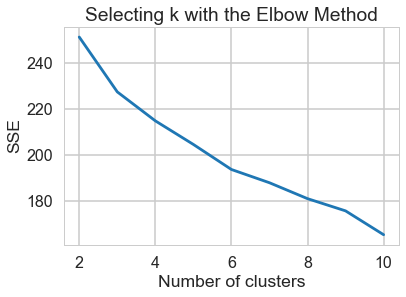

In [278]:
## Construct a plot showing  SSSS  for each  KK  and pick  KK  using this plot. For simplicity, test 2≤K≤10.
plt.plot(clusters, sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Selecting k with the Elbow Method')
plt.show()

In [279]:
## Make a bar chart showing the number of points in each cluster for k-means under the best K.
## Best K is 4??

best_model = KMeans(n_clusters=4)
best_label = best_model.fit_predict(x_cols)
print(best_label)

[3 0 1 3 0 2 1 3 2 3 2 1 3 0 0 1 0 1 3 2 3 0 2 2 1 2 0 0 0 0 0 0 2 2 0 3 2
 3 2 3 1 1 0 0 3 2 3 0 0 0 0 2 0 1 2 3 1 0 3 0 0 0 0 3 3 1 1 0 2 0 0 0 2 3
 0 3 1 2 0 0 2 0 0 1 3 3 3 0 0 0 0 3 0 3 2 2 3 0 0 2]


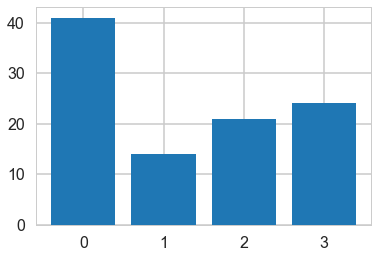

In [280]:
element, count = np.unique(best_label, return_counts=True)
plt.bar(element, count)
plt.show()

What challenges did you experience using the Elbow method to pick K?

Answer: In this case, the elbow is not obvious. It's a bit tricky to determine the optimal k. 

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.09365573283492713


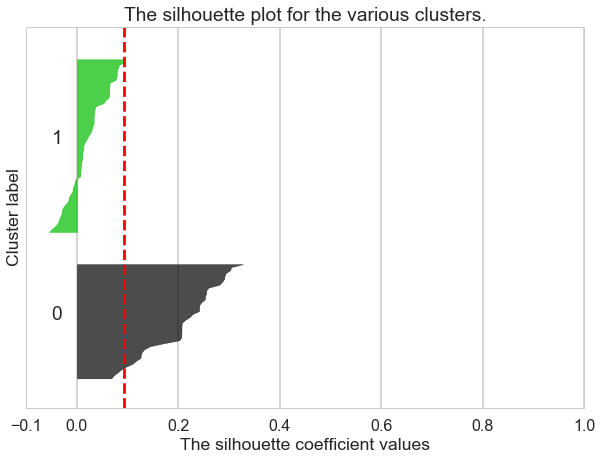

For n_clusters = 3 The average silhouette_score is : 0.11889942863638556


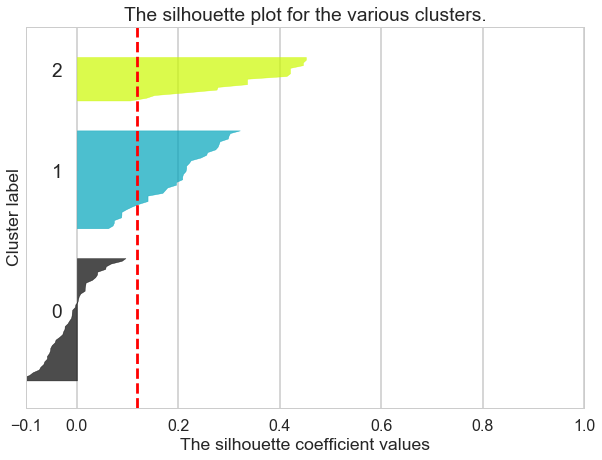

For n_clusters = 4 The average silhouette_score is : 0.12347053919571699


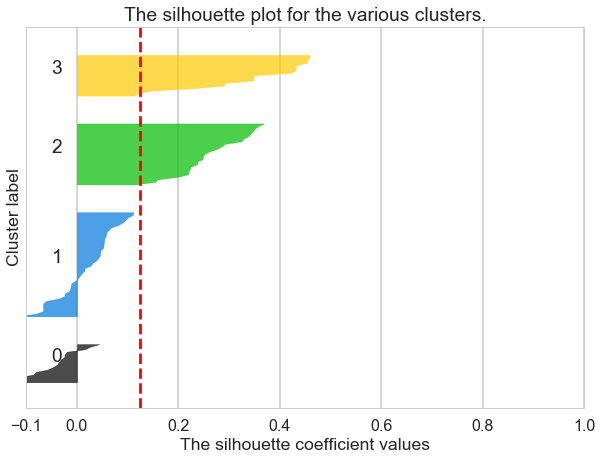

For n_clusters = 5 The average silhouette_score is : 0.14092516241984757


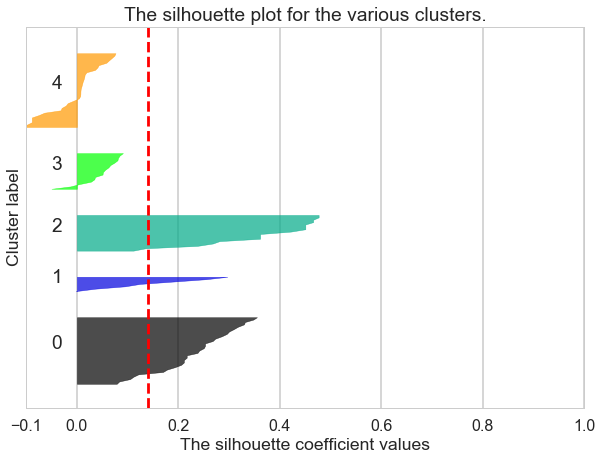

For n_clusters = 6 The average silhouette_score is : 0.1371798939109807


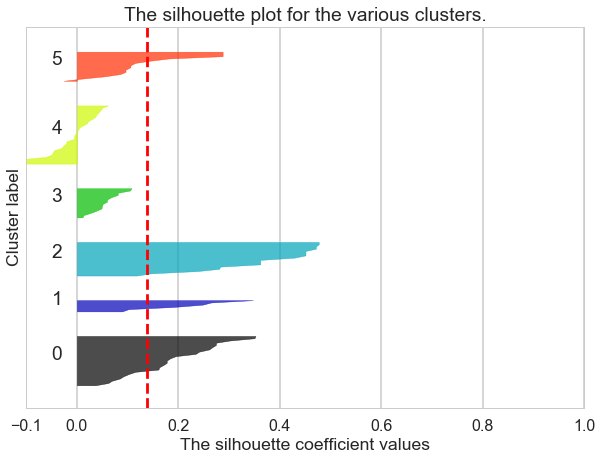

For n_clusters = 7 The average silhouette_score is : 0.1161092456616906


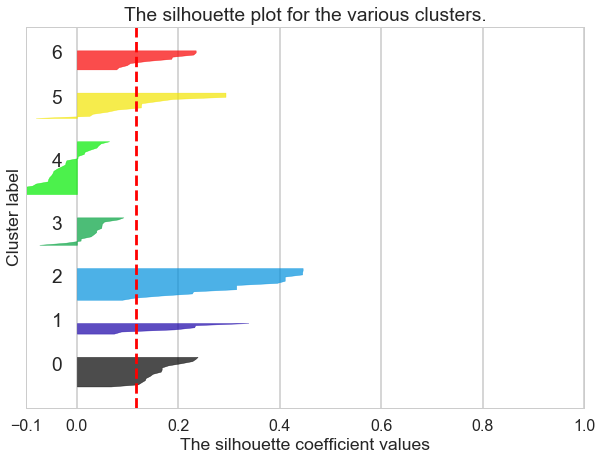

For n_clusters = 8 The average silhouette_score is : 0.11339573832632867


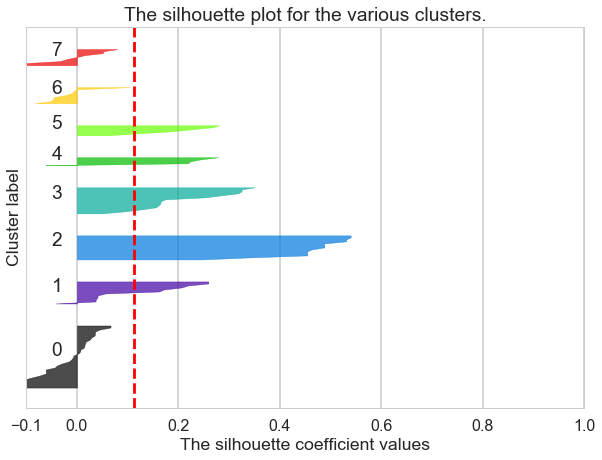

For n_clusters = 9 The average silhouette_score is : 0.12505960527779877


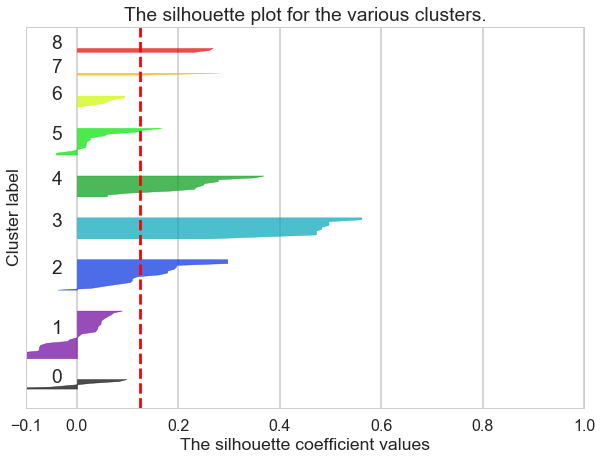

For n_clusters = 10 The average silhouette_score is : 0.11928332134753233


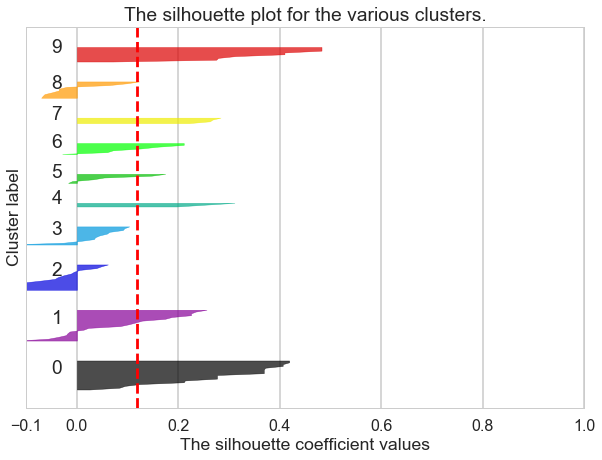

In [281]:
# Your turn.
## Using the documentation for the silhouette_score function above 
## construct a series of silhouette plots like the ones in the article linked above.

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

scores = []
s_clusters = range(2, 11)
for s_cluster in s_clusters:
    fig = plt.figure()
    ax1 = fig.gca()
    fig.set_size_inches(10, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (s_cluster + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    model_s = KMeans(n_clusters=s_cluster, random_state=10)
    label_s = model_s.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, label_s)
    scores.append((s_cluster, silhouette_avg))
    print("For n_clusters =", s_cluster,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, label_s)

    y_lower = 10
    for i in range(s_cluster):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[label_s == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / s_cluster)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()


[(2, 0.09365573283492713), (3, 0.11889942863638556), (4, 0.12347053919571699), (5, 0.14092516241984757), (6, 0.1371798939109807), (7, 0.1161092456616906), (8, 0.11339573832632867), (9, 0.12505960527779877), (10, 0.11928332134753233)]


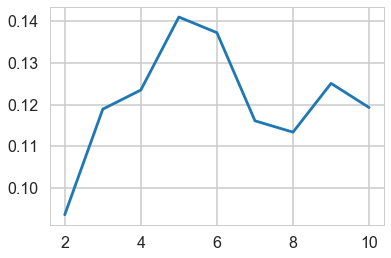

In [282]:
## Compute the average silhouette score for each  KK  and plot it. 

print(scores)
x, y = zip(*scores)
plt.plot(x, y)
plt.show()

What K does the plot suggest we should choose? Does it differ from what we found using the Elbow method?
Answer: Silhouette_score suggests we should choose k = 5. It's more obvious than what the Elbow method suggested. 

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [283]:
#your turn
## Use scikit-learn's PCA function to reduce the dimensionality of your clustering data to 2 components

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_cols)
pca_features = pca.transform(x_cols)

In [284]:
## Create a data frame with the following fields: customer name, cluster id, the two PCA components (label them x and y)

## re-run the KMeans with n_clusters=5 as suggested by silhouette method. 

model5 = KMeans(n_clusters=5)
label5 = model5.fit_predict(x_cols)
x = [item[0] for item in pca_features]
y = [item[1] for item in pca_features]
d = {"customer_name": df_pivot.index, "cluster_id": label5, "x": x, "y": y}
df = pd.DataFrame(d)
print(df.head())

  customer_name  cluster_id         x         y
0         Adams           3  1.007580  0.108215
1         Allen           1 -0.287539  0.044715
2      Anderson           2 -0.392032  1.038391
3        Bailey           3  0.699477 -0.022542
4         Baker           1  0.088183 -0.471695


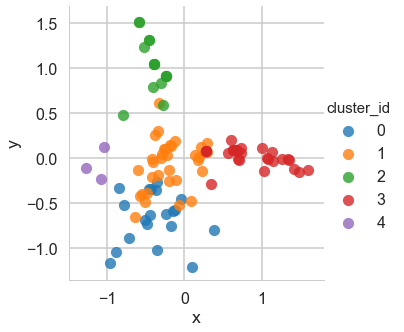

In [285]:
## Plot a scatterplot of the x vs y columns
##df.plot(kind="scatter", x="x", y="y", c="cluster_id")
sns.lmplot(x="x", y="y", data=df, hue="cluster_id", fit_reg=False)

It looks like there are 4 to 5 clusters, even though some of them are pretty close to each other. Both elbow and silhouette methods gave a pretty good prediction of k. 

In [286]:
## add cluster_id to the original dataframe
df_cluster = df_merge.merge(df, on="customer_name", how="inner")
##df_cluster = df_cluster.iloc[:, :-2]
print(df_cluster.head())

  customer_name  offer_id  n   campaign    varietal  min_qty  discount  \
0         Smith         2  1    January  Pinot Noir       72        17   
1         Smith        24  1  September  Pinot Noir        6        34   
2     Rodriguez         2  1    January  Pinot Noir       72        17   
3     Rodriguez        26  1    October  Pinot Noir      144        83   
4        Martin         2  1    January  Pinot Noir       72        17   

      origin  past_peak  cluster_id         x         y  
0     France      False           2 -0.300227  0.829765  
1      Italy      False           2 -0.300227  0.829765  
2     France      False           2 -0.403273  0.786296  
3  Australia      False           2 -0.403273  0.786296  
4     France      False           1 -0.382241  0.254034  


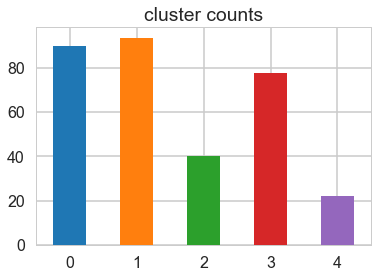

In [306]:
## to visualize the number of items in each cluster
item_count = df_cluster.cluster_id.value_counts().sort_index()
item_count.plot(kind="bar", title='cluster counts', rot=0)

In [362]:
## campaigns
best_camp = df_cluster.campaign.value_counts()
print(best_camp)
df_camp = df_cluster.pivot_table(index="cluster_id", columns="campaign", values="n", aggfunc="count", fill_value=0)
print(df_camp)

March        51
December     43
August       31
October      30
July         26
May          24
November     23
February     22
January      20
June         20
April        17
September    17
Name: campaign, dtype: int64
campaign    April  August  December  February  January  July  June  March  \
cluster_id                                                                  
0               4      22        12         7        7     4     6     12   
1               9       6        15        10        4     3    11     10   
2               1       0         0         0        7     7     0      0   
3               1       0        16         0        0    12     0     28   
4               2       3         0         5        2     0     3      1   

campaign    May  November  October  September  
cluster_id                                     
0             7         2        5          2  
1             9         6        9          2  
2             0         0       12         13  

In [358]:
test = df_cluster.pivot_table(index="campaign", columns="varietal", values="n", aggfunc="count", margins=True, fill_value=0)
print(test)

varietal   Cabernet Sauvignon  Champagne  Chardonnay  Espumante  Malbec  \
campaign                                                                  
April                       0          0          10          0       0   
August                      6         25           0          0       0   
December                    4         17           0          0      22   
February                    4         12           0          6       0   
January                     0          0           0          0      10   
July                        0          5           0         14       0   
June                        6          0           0          0       0   
March                       0          0           0         20       0   
May                         0         13           0          0       0   
November                    6          0           0          0       0   
October                     6          9           0          0       0   
September                

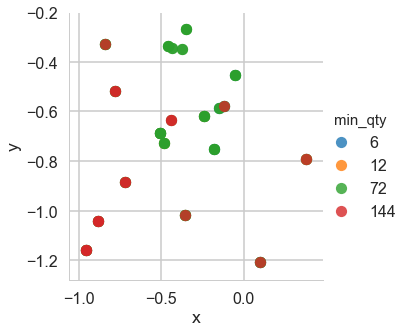

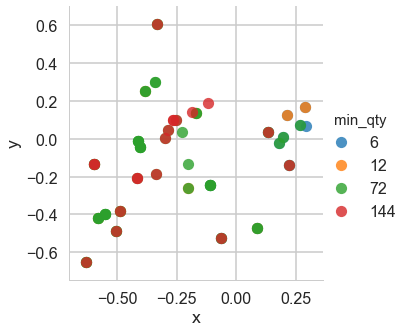

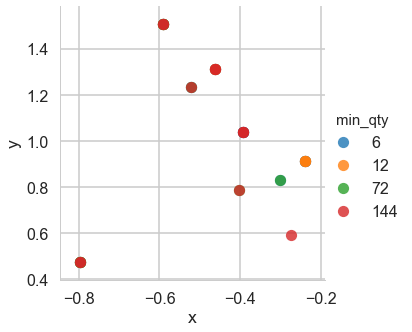

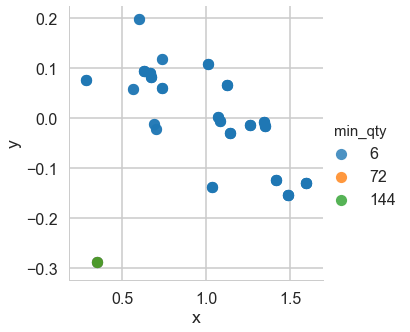

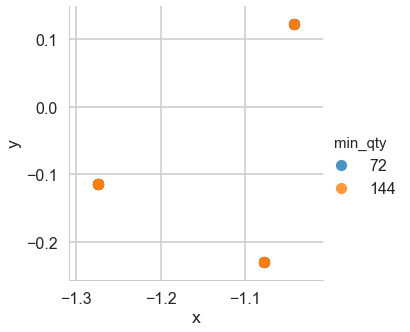

In [342]:
 ## min_qty in clusters
c_range = range(0, 5)
for r in c_range:
    df_min_qty = df_cluster[df_cluster.cluster_id==r]
    sns.lmplot(x="x", y="y", data=df_min_qty, hue="min_qty", fit_reg=False)

In [ ]:
## add a new column to indicate if the wine is red or white
rw = {"Pinot Noir": "red", "Cabernet Sauvignon": "red", "Malbec": "red", "Merlot": "red", 
      "Champagne": "white", "Prosecco": "white", "Espumante": "white", "Pinot Grigio": "white", "Chardonnay": "white"}
df_cluster['red_white'] = df_cluster['varietal'].map(rw)
print(df_cluster.head(2))

## plot the wine type in each cluster
c_range = range(0, 5)
for r in c_range:
    df_plot = df_cluster[df_cluster.cluster_id==r]
    lm = sns.lmplot(x="x", y="y", data=df_plot, hue="red_white", fit_reg=False, size=4)
    lm.fig.suptitle("cluster "+str(r), size=15)
    lm.ax.set_xlabel('')
    lm.ax.set_ylabel('')

We can notice that most of the red wine are bought by customers in cluster 2. In fact, cluster 2 bought almost only Pinot Noir. 

In [331]:
df_cluster["is_2"] = df_cluster.cluster_id==2
df_cluster.groupby("is_2")["varietal"].value_counts()

is_2   varietal          
False  Champagne             80
       Prosecco              42
       Espumante             40
       Cabernet Sauvignon    32
       Malbec                31
       Merlot                20
       Pinot Grigio          17
       Chardonnay            14
       Pinot Noir             8
True   Pinot Noir            36
       Champagne              1
       Chardonnay             1
       Malbec                 1
       Prosecco               1
Name: varietal, dtype: int64

In [363]:
print(df_cluster["min_qty"].unique())
print(df_cluster["discount"].unique())
print(df_cluster["past_peak"].unique())
df_cluster.groupby("cluster_id")[["min_qty", "discount", "past_peak"]].mean()

[ 72   6 144  12]
[17 34 83 56 85 63 19 52 39 88 47 89 54 64 48 57 44 82 86 59 50 40 87 43
 45 32 66]
[False  True]


,min_qty,discount,past_peak
cluster_id,,,
0,72.866667,60.877778,0.166667
1,73.723404,64.787234,0.255319
2,63.300000,49.675000,0.000000
3,8.615385,55.384615,0.153846
4,101.454545,63.454545,0.272727


   customer_name  offer_id  n campaign   varietal  min_qty  discount  \
6         Martin        11  1      May  Champagne       72        85   
8        Jackson        22  1   August  Champagne       72        63   
11       Jackson        11  1      May  Champagne       72        85   
22      Peterson        27  1  October  Champagne       72        88   
32        Fisher        22  1   August  Champagne       72        63   

         origin  past_peak  cluster_id         x         y red_white   is_2  
6        France      False           1 -0.382241  0.254034     white  False  
8        France      False           0 -0.839578 -0.328823     white  False  
11       France      False           0 -0.839578 -0.328823     white  False  
22  New Zealand      False           2 -0.797379  0.475995     white   True  
32       France      False           0 -0.509137 -0.687321     white  False  


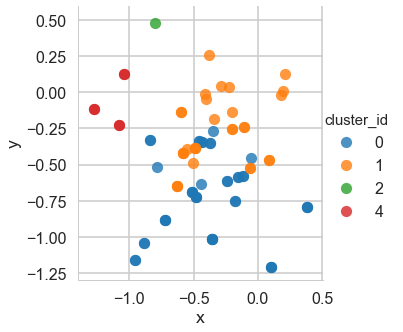

In [366]:
champagne = df_cluster[df_cluster["varietal"]=="Champagne"]
print(champagne.head())
sns.lmplot(x="x", y="y", data=champagne, hue="cluster_id", fit_reg=False)

#### Conclusion:
Some of the observations from the above analysis include:
* The customers in cluster 2 are the biggest buyers for Pinot Noir and they are willing to buy fresher wine with a low discount.
* The customers in cluster 3 like to buy wine in smaller quantity, and those in cluster 4 often bought wine in bulk.
* March campaigns result in the most sales, followed by December, August, and October, around holidays.
* Among all the wines, Champagne is the most popular. Customers who bought Champagne are mostly in cluster 0 and 1. 

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

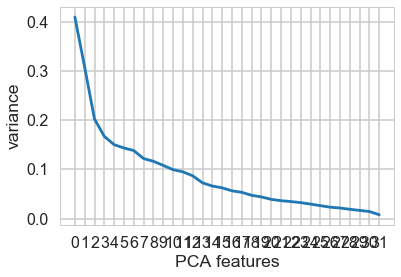

In [373]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)
features = range(pca.n_components_)
plt.plot(features, pca.explained_variance_)
plt.xlabel('PCA features')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

Answer: The possible value for the optimal number of dimensions could be 3 or 4. 

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [378]:
# Your turn
## 1. Affinity propagation
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

af = AffinityPropagation().fit(x_cols)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(x_cols, labels, metric='sqeuclidean'))

Estimated number of clusters: 14
Silhouette Coefficient: 0.180


In [400]:
## 2. Spectral clustering
from sklearn.cluster import SpectralClustering

n_clusters = range(2,11)
for n in n_clusters:
    sp = SpectralClustering(n_clusters=n).fit(x_cols)
    labels = sp.labels_
    print(n, "clusters:", "Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(x_cols, labels, metric='sqeuclidean'))

2 clusters: Silhouette Coefficient: 0.064
3 clusters: Silhouette Coefficient: 0.133
4 clusters: Silhouette Coefficient: 0.002
5 clusters: Silhouette Coefficient: -0.023
6 clusters: Silhouette Coefficient: -0.020
7 clusters: Silhouette Coefficient: 0.025
8 clusters: Silhouette Coefficient: 0.029
9 clusters: Silhouette Coefficient: -0.004
10 clusters: Silhouette Coefficient: -0.017


Optimal number of clusters: 3

In [402]:
## 3. Agglomerative clustering
from sklearn.cluster import AgglomerativeClustering

n_clusters = range(2,11)
for n in n_clusters:
    ag = AgglomerativeClustering(n_clusters=n).fit(x_cols)
    labels = ag.labels_
    print(n, "clusters:", "Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(x_cols, labels, metric='sqeuclidean'))

2 clusters: Silhouette Coefficient: 0.123
3 clusters: Silhouette Coefficient: 0.173
4 clusters: Silhouette Coefficient: 0.196
5 clusters: Silhouette Coefficient: 0.219
6 clusters: Silhouette Coefficient: 0.232
7 clusters: Silhouette Coefficient: 0.243
8 clusters: Silhouette Coefficient: 0.251
9 clusters: Silhouette Coefficient: 0.189
10 clusters: Silhouette Coefficient: 0.132


Optimal number of clusters: 8

In [480]:
## 4. DBSCAN
from sklearn.cluster import DBSCAN
min_sample = range(1,4)
for n in min_sample:
    db = DBSCAN(min_samples=n).fit(x_cols)
    labels = db.labels_
    print("min_samples", n, "Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(x_cols, labels, metric='sqeuclidean'))

min_samples 1 Silhouette Coefficient: 0.190
min_samples 2 Silhouette Coefficient: -0.172
min_samples 3 Silhouette Coefficient: -0.259


Optimal min_samples = 1

How do their results compare? Which performs the best? Tell a story why you think it performs the best.
Silhouette Scores
Affinity propagation: 0.180
Spectral clustering: 0.133
Agglomerative clustering: 0.251
DBSCAN: 0.190
The best performing algorithm is Agglomerative clustering with a Silhouette score of 0.251. In this dataset, most of the clusters are close to each other, which results in a low Silhouette score overall. As we can see from the PCA scatter plot, the elements form a long thin shape. K-means works best when data is globular and hierarchical clustering (Agglomerative clustering) performs better when the data is more spread out. 